<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/VAE-DCGAN/blob/main/VAE_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from time import time
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

In [ ]:
# Set the device to GPU if available; otherwise, fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define a series of transformations for the dataset.
# 1. Convert images to PyTorch tensors.
# 2. Normalize images with a mean and standard deviation of 0.5 for each RGB channel.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        # Encoder: compresses the input into a latent representation.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Fully connected layers for generating the mean and log-variance of the latent distribution.
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 64 * 8 * 8)
        # Decoder: reconstructs the input from the latent representation.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick for backpropagating through the sampling process.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
      # Forward pass through the encoder.
        h = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.fc_decode(z).view(x.size(0), 64, 8, 8)
        # Forward pass through the decoder to reconstruct the input.
        return self.decoder(h_dec), mu, logvar

In [ ]:
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (Mean Squared Error) to measure how well the input is reconstructed.
    # 'reduction=sum' ensures that the loss is summed over all pixels.
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Initialize the VAE model and move it to the selected device (GPU or CPU).
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0002)

# Lists to store training and evaluation metrics for analysis.
train_loss_vae = []
test_loss_vae = []
vae_epoch_times = []
vae_accuracies = []

num_epochs = 150
start_training_time = time()  # Start overall training time tracking

# Training loop over the specified number of epochs.
for epoch in range(num_epochs):
    start_time = time()  # Start epoch-specific time tracking
    vae.train()
    train_loss = 0
    total_mse = 0.
    total_samples = 0.

    # Iterate over the training data.
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # Calculate MSE per sample
        mse_per_sample = ((data - recon_batch) ** 2).mean(dim=(1, 2, 3))
        total_mse += mse_per_sample.sum().item()
        total_samples += data.size(0)

    avg_mse = total_mse / total_samples
    approx_accuracy = 1 - avg_mse  # Higher value means better reconstruction
    vae_accuracies.append(approx_accuracy)
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_loss_vae.append(avg_train_loss)

    # Calculate and store the epoch time
    epoch_time = time() - start_time
    vae_epoch_times.append(epoch_time)
    print(f'Epoch {epoch + 1} for VAE took {epoch_time:.2f} seconds')
    print(f'        VAE Approx Training Accuracy: {approx_accuracy:.4f}') # for better presentation in the output I left 8 spaces at the beginning of print statement

    # Evaluate on the test set
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)  # Ensure mu and logvar are recalculated here
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_loss_vae.append(avg_test_loss)

    print(f'        Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}\n\n') # for better presentation in the output I left 8 spaces at the beginning of print statement

total_vae_training_time = time() - start_training_time
print(f'Total VAE Training Time: {total_vae_training_time:.2f} seconds')

# Calculate cumulative training time for plotting
cumulative_time_vae = np.cumsum(vae_epoch_times)

Epoch 1 for VAE took 14.20 seconds
        VAE Approx Training Accuracy: 0.7602
        Train Loss: 771.9025, Test Loss: 614.4775


Epoch 2 for VAE took 14.66 seconds
        VAE Approx Training Accuracy: 0.8104
        Train Loss: 610.1930, Test Loss: 593.0753


Epoch 3 for VAE took 15.67 seconds
        VAE Approx Training Accuracy: 0.8159
        Train Loss: 595.2460, Test Loss: 581.6721


Epoch 4 for VAE took 16.55 seconds
        VAE Approx Training Accuracy: 0.8206
        Train Loss: 581.7513, Test Loss: 562.2307


Epoch 5 for VAE took 14.65 seconds
        VAE Approx Training Accuracy: 0.8265
        Train Loss: 564.5623, Test Loss: 551.2725


Epoch 6 for VAE took 16.55 seconds
        VAE Approx Training Accuracy: 0.8291
        Train Loss: 556.3796, Test Loss: 544.6834


Epoch 7 for VAE took 15.57 seconds
        VAE Approx Training Accuracy: 0.8308
        Train Loss: 551.4555, Test Loss: 540.8919


Epoch 8 for VAE took 14.13 seconds
        VAE Approx Training Accuracy: 0.8

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        # The generator model uses a series of linear and convolutional layers to generate images from a latent vector.
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),

            # Transposed convolution layers for upsampling the image.
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Final convolution to produce a 3-channel RGB image.
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # The discriminator model uses convolutional layers to classify if an image is real or generated.
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Flatten the output and apply dropout to prevent overfitting.
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass to classify the input image as real or fake.
        return self.model(x)

In [ ]:
latent_dim = 128 # Size of the latent vector for generating images.
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss() # Loss function for binary classification.

# Optimizers for updating the weights of generator and discriminator.
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lists to store training metrics.
train_loss_dcgan = []
test_loss_dcgan = []
dcgan_accuracies = []
dcgan_epoch_times = []  # List to store time taken for each epoch

num_epochs = 150
dcgan_training_time = time()  # Start overall training time tracking

# Training loop for the specified number of epochs.
for epoch in range(num_epochs):
    start_time = time()  # Start time for the current epoch
    correct_preds = 0
    total_preds = 0
    train_loss_d = 0
    train_loss_g = 0

    generator.train()
    discriminator.train()

    # Iterate through training data batches.
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Create labels for real and fake data.
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator on real images.
        outputs = discriminator(real_images)
        predictions_real = (outputs > 0.5).float()
        correct_preds += (predictions_real == real_labels).sum().item()
        total_preds += real_labels.size(0)
        d_loss_real = criterion(outputs, real_labels)

        # Generate fake images from random noise.
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        predictions_fake = (outputs < 0.5).float()
        correct_preds += (predictions_fake == fake_labels).sum().item()
        total_preds += fake_labels.size(0)
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss.
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        train_loss_d += d_loss.item()

        # Train Generator
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        train_loss_g += g_loss.item()

        # Calculate discriminator accuracy for training accuracy metric
        predictions = (outputs > 0.5).float()
        correct_preds += (predictions == real_labels).sum().item()
        total_preds += real_labels.size(0)

    # Calculate accuracy for the epoch.
    dcgan_accuracy = correct_preds / total_preds
    dcgan_accuracies.append(dcgan_accuracy)

    avg_train_loss_d = train_loss_d / len(train_loader)
    avg_train_loss_g = train_loss_g / len(train_loader)
    train_loss_dcgan.append(avg_train_loss_g)

    # Evaluate Generator on the test set
    generator.eval()
    test_loss_g = 0
    with torch.no_grad():
        for data, _ in test_loader:
            batch_size = data.size(0)
            z = torch.randn(batch_size, latent_dim, device=device)
            generated_images = generator(z)
            outputs = discriminator(generated_images)

            real_labels = torch.ones(batch_size, 1).to(device)
            loss = criterion(outputs, real_labels)
            test_loss_g += loss.item()

    avg_test_loss_g = test_loss_g / len(test_loader)
    test_loss_dcgan.append(avg_test_loss_g)

    epoch_time = time() - start_time  # Calculate time taken for the current epoch
    dcgan_epoch_times.append(epoch_time)  # Append to the list of epoch times
    accuracy = correct_preds / total_preds  # Calculate accuracy for the epoch
    dcgan_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}, DCGAN Discriminator Training Accuracy: {accuracy:.4f}')
    # Print epoch time and losses in one line
    print(f'Epoch {epoch + 1} took {epoch_time:.2f} seconds | Train Loss D: {avg_train_loss_d:.4f} | Train Loss G: {avg_train_loss_g:.4f} | Test Loss G: {avg_test_loss_g:.4f}')

dcgan_training_time = time() - dcgan_training_time  # End overall training time tracking
print(f'Total DCGAN Training Time: {dcgan_training_time:.2f} seconds')

# Calculate cumulative training time for plotting
cumulative_time_dcgan = np.cumsum(dcgan_epoch_times)

Epoch 1, DCGAN Discriminator Training Accuracy: 0.3217
Epoch 1 took 32.82 seconds | Train Loss D: 0.9415 | Train Loss G: 1.9605 | Test Loss G: 1.3876
Epoch 2, DCGAN Discriminator Training Accuracy: 0.3391
Epoch 2 took 32.29 seconds | Train Loss D: 0.8766 | Train Loss G: 2.0753 | Test Loss G: 1.1217
Epoch 3, DCGAN Discriminator Training Accuracy: 0.3699
Epoch 3 took 32.75 seconds | Train Loss D: 1.1894 | Train Loss G: 1.4102 | Test Loss G: 1.3983
Epoch 4, DCGAN Discriminator Training Accuracy: 0.3828
Epoch 4 took 32.47 seconds | Train Loss D: 1.1669 | Train Loss G: 1.2850 | Test Loss G: 0.9861
Epoch 5, DCGAN Discriminator Training Accuracy: 0.3716
Epoch 5 took 33.02 seconds | Train Loss D: 1.0503 | Train Loss G: 1.4702 | Test Loss G: 1.4219
Epoch 6, DCGAN Discriminator Training Accuracy: 0.3620
Epoch 6 took 33.23 seconds | Train Loss D: 0.9607 | Train Loss G: 1.6818 | Test Loss G: 1.4727
Epoch 7, DCGAN Discriminator Training Accuracy: 0.3745
Epoch 7 took 32.50 seconds | Train Loss D: 1.

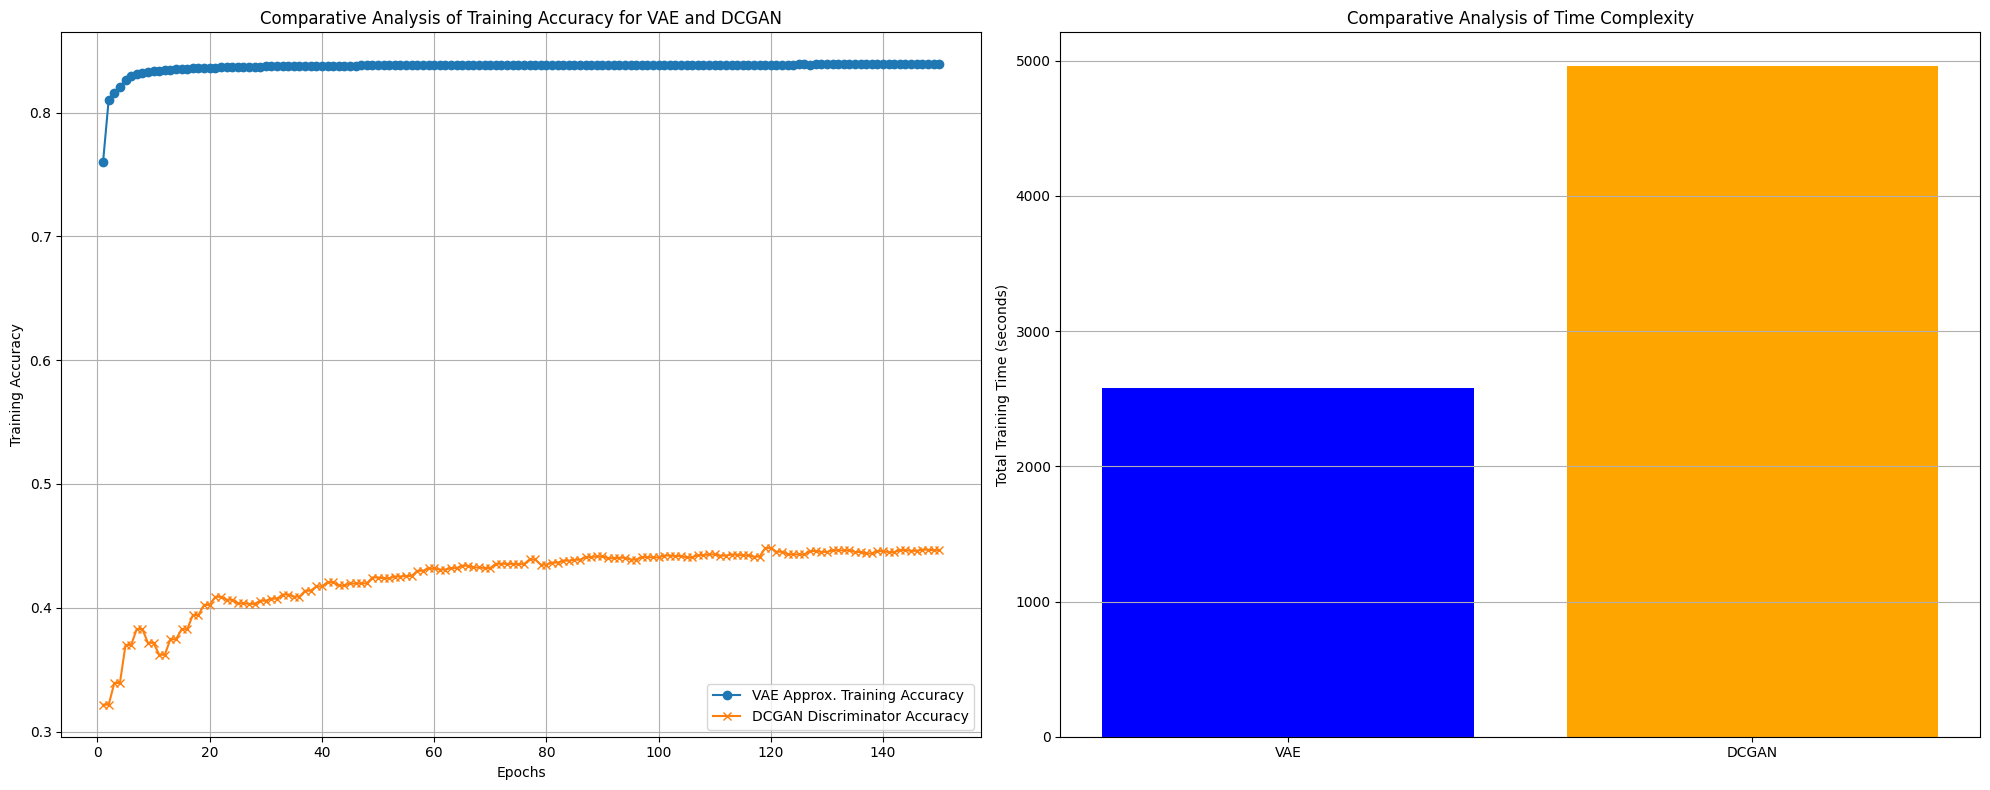

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure epochs are aligned for plotting
min_epochs = min(len(vae_accuracies), len(dcgan_accuracies))
epochs = range(1, min_epochs + 1)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Comparative analysis of training accuracy
axes[0].plot(epochs, vae_accuracies[:min_epochs], label='VAE Approx. Training Accuracy', marker='o')
axes[0].plot(epochs, dcgan_accuracies[:min_epochs], label='DCGAN Discriminator Accuracy', marker='x')
axes[0].set_title('Comparative Analysis of Training Accuracy for VAE and DCGAN')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Time complexity comparison
model_names = ['VAE', 'DCGAN']
training_times = [total_vae_training_time, dcgan_training_time]

axes[1].bar(model_names, training_times, color=['blue', 'orange'])
axes[1].set_title('Comparative Analysis of Time Complexity')
axes[1].set_ylabel('Total Training Time (seconds)')
axes[1].grid(axis='y')

# Display the plots
plt.tight_layout()
plt.show()

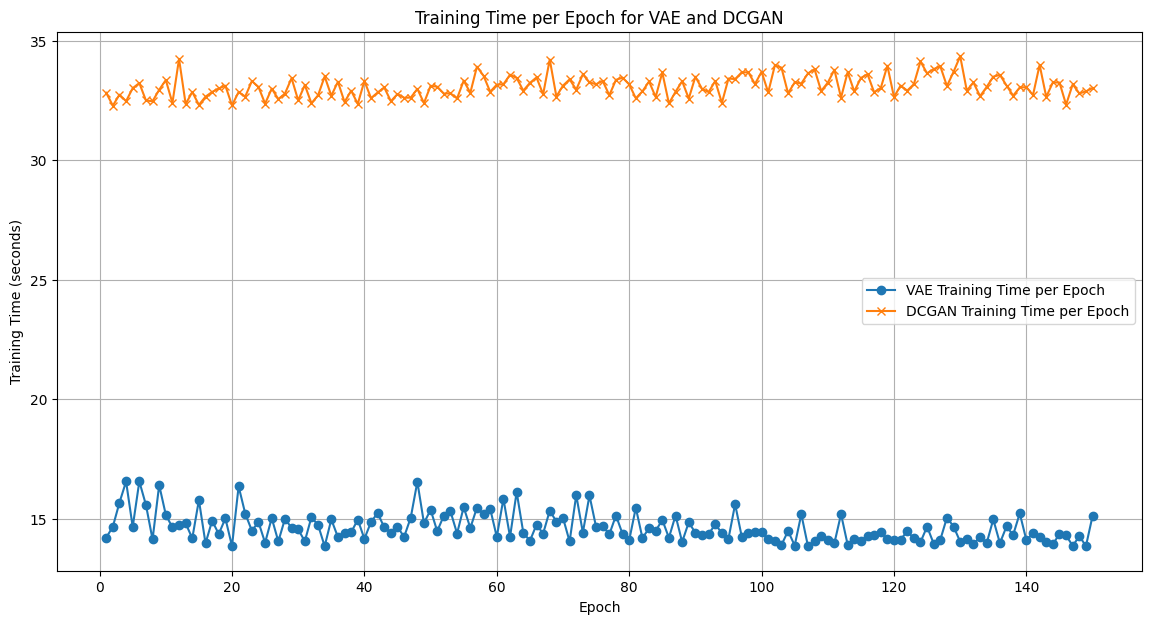

In [ ]:
import matplotlib.pyplot as plt

# Generate epoch numbers for plotting
epochs = range(1, len(vae_epoch_times) + 1)

# Plot training time per epoch for VAE and DCGAN
plt.figure(figsize=(14, 7))
plt.plot(epochs, vae_epoch_times, label='VAE Training Time per Epoch', marker='o')
plt.plot(epochs, dcgan_epoch_times[:len(epochs)], label='DCGAN Training Time per Epoch', marker='x')
plt.title('Training Time per Epoch for VAE and DCGAN')
plt.xlabel('Epoch')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Quantitative comparison
# Function to calculate MSE and SSIM
def calculate_metrics(original, generated):
    original = original.cpu().numpy().transpose(1, 2, 0)
    generated = generated.cpu().detach().numpy().transpose(1, 2, 0)
    mse_value = mean_squared_error(original.flatten(), generated.flatten())
    ssim_value = ssim(original, generated, data_range=generated.max() - generated.min(), win_size=3)
    return mse_value, ssim_value

num_samples_to_evaluate = 150  # The number of samples to evaluate

# Usage for VAE
print("VAE:")
vae.eval()
with torch.no_grad():
    for i in range(num_samples_to_evaluate):
        original_image = next(iter(train_loader))[0][0].to(device)  # Get new sample for each evaluation
        reconstructed_image, _, _ = vae(original_image.unsqueeze(0))
        mse_vae, ssim_vae = calculate_metrics(original_image, reconstructed_image.squeeze(0))
        print(f'Sample {i + 1} - MSE: {mse_vae:.4f}, SSIM: {ssim_vae:.4f}')

# Usage for DCGAN
print("\nDCGAN:")
generator.eval()
with torch.no_grad():
    for i in range(num_samples_to_evaluate):
        z = torch.randn(1, latent_dim, device=device)
        generated_image = generator(z).squeeze(0)

        # Generate a new original image for fair comparison or use a consistent test set image
        original_image = next(iter(test_loader))[0][0].to(device)

        mse_dcgan, ssim_dcgan = calculate_metrics(original_image, generated_image)
        print(f'Sample {i + 1} - MSE: {mse_dcgan:.4f}, SSIM: {ssim_dcgan:.4f}')

VAE:
Sample 1 - MSE: 0.2496, SSIM: 0.1403
Sample 2 - MSE: 0.3670, SSIM: -0.0072
Sample 3 - MSE: 0.1638, SSIM: 0.1083
Sample 4 - MSE: 0.1026, SSIM: 0.2034
Sample 5 - MSE: 0.1572, SSIM: 0.0781
Sample 6 - MSE: 0.2806, SSIM: -0.0017
Sample 7 - MSE: 0.1155, SSIM: 0.0660
Sample 8 - MSE: 0.1513, SSIM: 0.2574
Sample 9 - MSE: 0.3204, SSIM: 0.0672
Sample 10 - MSE: 0.1320, SSIM: 0.1921
Sample 11 - MSE: 0.0846, SSIM: 0.0480
Sample 12 - MSE: 0.0498, SSIM: 0.0669
Sample 13 - MSE: 0.0914, SSIM: 0.2346
Sample 14 - MSE: 0.1037, SSIM: 0.2041
Sample 15 - MSE: 0.1091, SSIM: 0.3207
Sample 16 - MSE: 0.1015, SSIM: 0.2729
Sample 17 - MSE: 0.2029, SSIM: -0.0038
Sample 18 - MSE: 0.1842, SSIM: 0.1704
Sample 19 - MSE: 0.1990, SSIM: 0.0009
Sample 20 - MSE: 0.1201, SSIM: 0.1672
Sample 21 - MSE: 0.0973, SSIM: 0.2099
Sample 22 - MSE: 0.0938, SSIM: 0.1510
Sample 23 - MSE: 0.3293, SSIM: 0.0022
Sample 24 - MSE: 0.2292, SSIM: 0.0522
Sample 25 - MSE: 0.1978, SSIM: 0.2214
Sample 26 - MSE: 0.1716, SSIM: 0.1544
Sample 27 - M

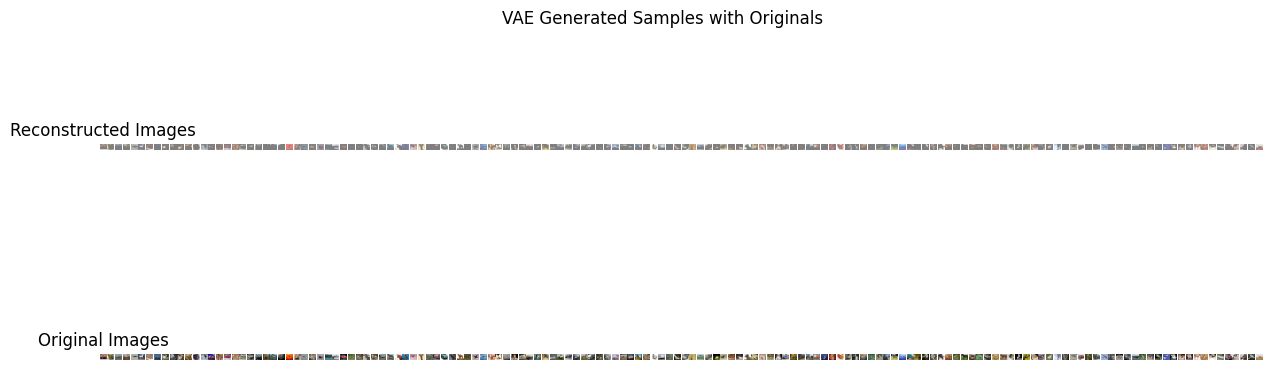

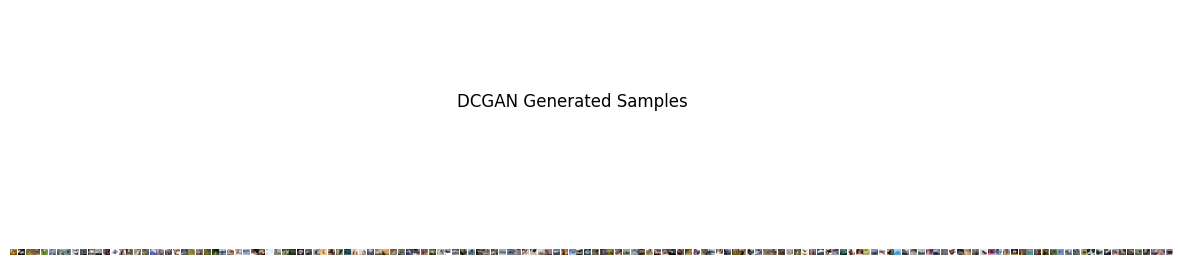

In [ ]:
# Function to display images with their original counterparts for VAE
def show_images_with_originals(reconstructed, originals, title):
    fig, axes = plt.subplots(2, len(reconstructed), figsize=(15, 5))
    for i, (recon, orig) in enumerate(zip(reconstructed, originals)):
        # Display reconstructed image
        recon_img = recon.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        recon_img = np.clip(recon_img, 0, 1)  # Ensure valid range
        axes[0, i].imshow(recon_img)
        axes[0, i].axis('off')

        # Display original image
        orig_img = orig.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        orig_img = np.clip(orig_img, 0, 1)
        axes[1, i].imshow(orig_img)
        axes[1, i].axis('off')

    axes[0, 0].set_title('Reconstructed Images')
    axes[1, 0].set_title('Original Images')
    plt.suptitle(title)
    plt.show()

# Generate and display images from VAE with original images
vae.eval()
vae_images = []
original_images = []
with torch.no_grad():
    for i in range(150):
        original_image = next(iter(train_loader))[0][0].to(device)
        reconstructed_image, _, _ = vae(original_image.unsqueeze(0))
        vae_images.append(reconstructed_image.squeeze(0))
        original_images.append(original_image)

show_images_with_originals(vae_images, original_images, 'VAE Generated Samples with Originals')

# Function to display only generated images
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()

# Generate and display images from DCGAN
generator.eval()
dcgan_images = []
with torch.no_grad():
    for i in range(150):
        z = torch.randn(1, latent_dim, device=device)
        generated_image = generator(z)
        dcgan_images.append(generated_image.squeeze(0))

show_images(dcgan_images, '\n\n\n\nDCGAN Generated Samples')

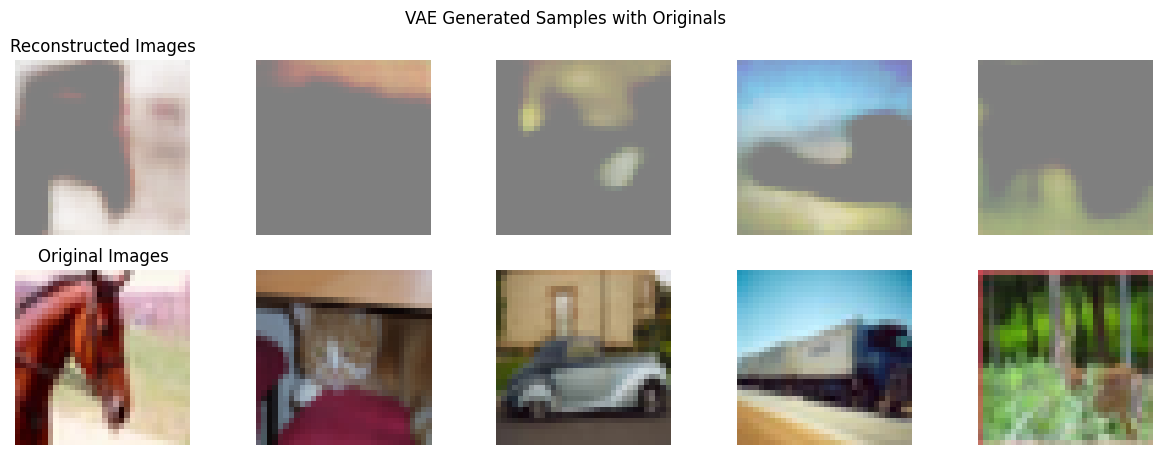

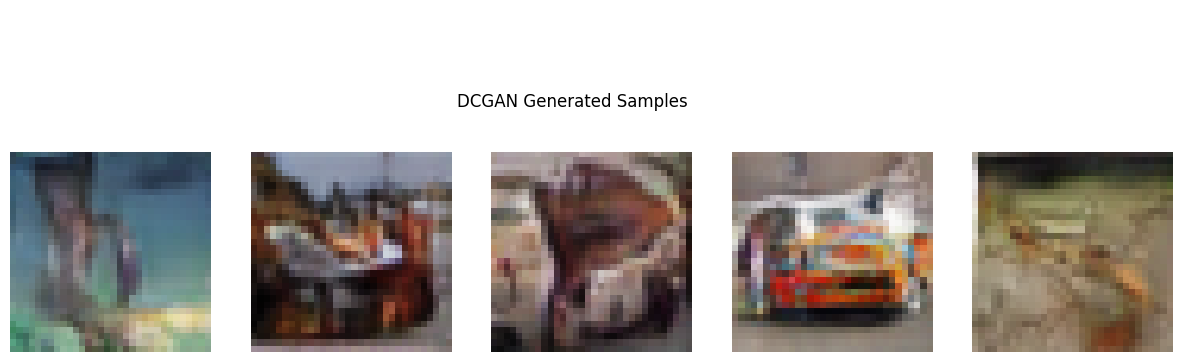

In [ ]:
# Function to display images with their original counterparts for VAE
def show_images_with_originals(reconstructed, originals, title):
    fig, axes = plt.subplots(2, len(reconstructed), figsize=(15, 5))
    for i, (recon, orig) in enumerate(zip(reconstructed, originals)):
        # Display reconstructed image
        recon_img = recon.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        recon_img = np.clip(recon_img, 0, 1)  # Ensure valid range
        axes[0, i].imshow(recon_img)
        axes[0, i].axis('off')

        # Display original image
        orig_img = orig.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        orig_img = np.clip(orig_img, 0, 1)
        axes[1, i].imshow(orig_img)
        axes[1, i].axis('off')

    axes[0, 0].set_title('Reconstructed Images')
    axes[1, 0].set_title('Original Images')
    plt.suptitle(title)
    plt.show()

# Generate and display images from VAE with original images
vae.eval()
vae_images = []
original_images = []
with torch.no_grad():
    for i in range(5):
        original_image = next(iter(train_loader))[0][0].to(device)
        reconstructed_image, _, _ = vae(original_image.unsqueeze(0))
        vae_images.append(reconstructed_image.squeeze(0))
        original_images.append(original_image)

show_images_with_originals(vae_images, original_images, 'VAE Generated Samples with Originals')

# Function to display only generated images
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()

# Generate and display images from DCGAN
generator.eval()
dcgan_images = []
with torch.no_grad():
    for i in range(5):
        z = torch.randn(1, latent_dim, device=device)
        generated_image = generator(z)
        dcgan_images.append(generated_image.squeeze(0))

show_images(dcgan_images, '\n\n\n\nDCGAN Generated Samples')

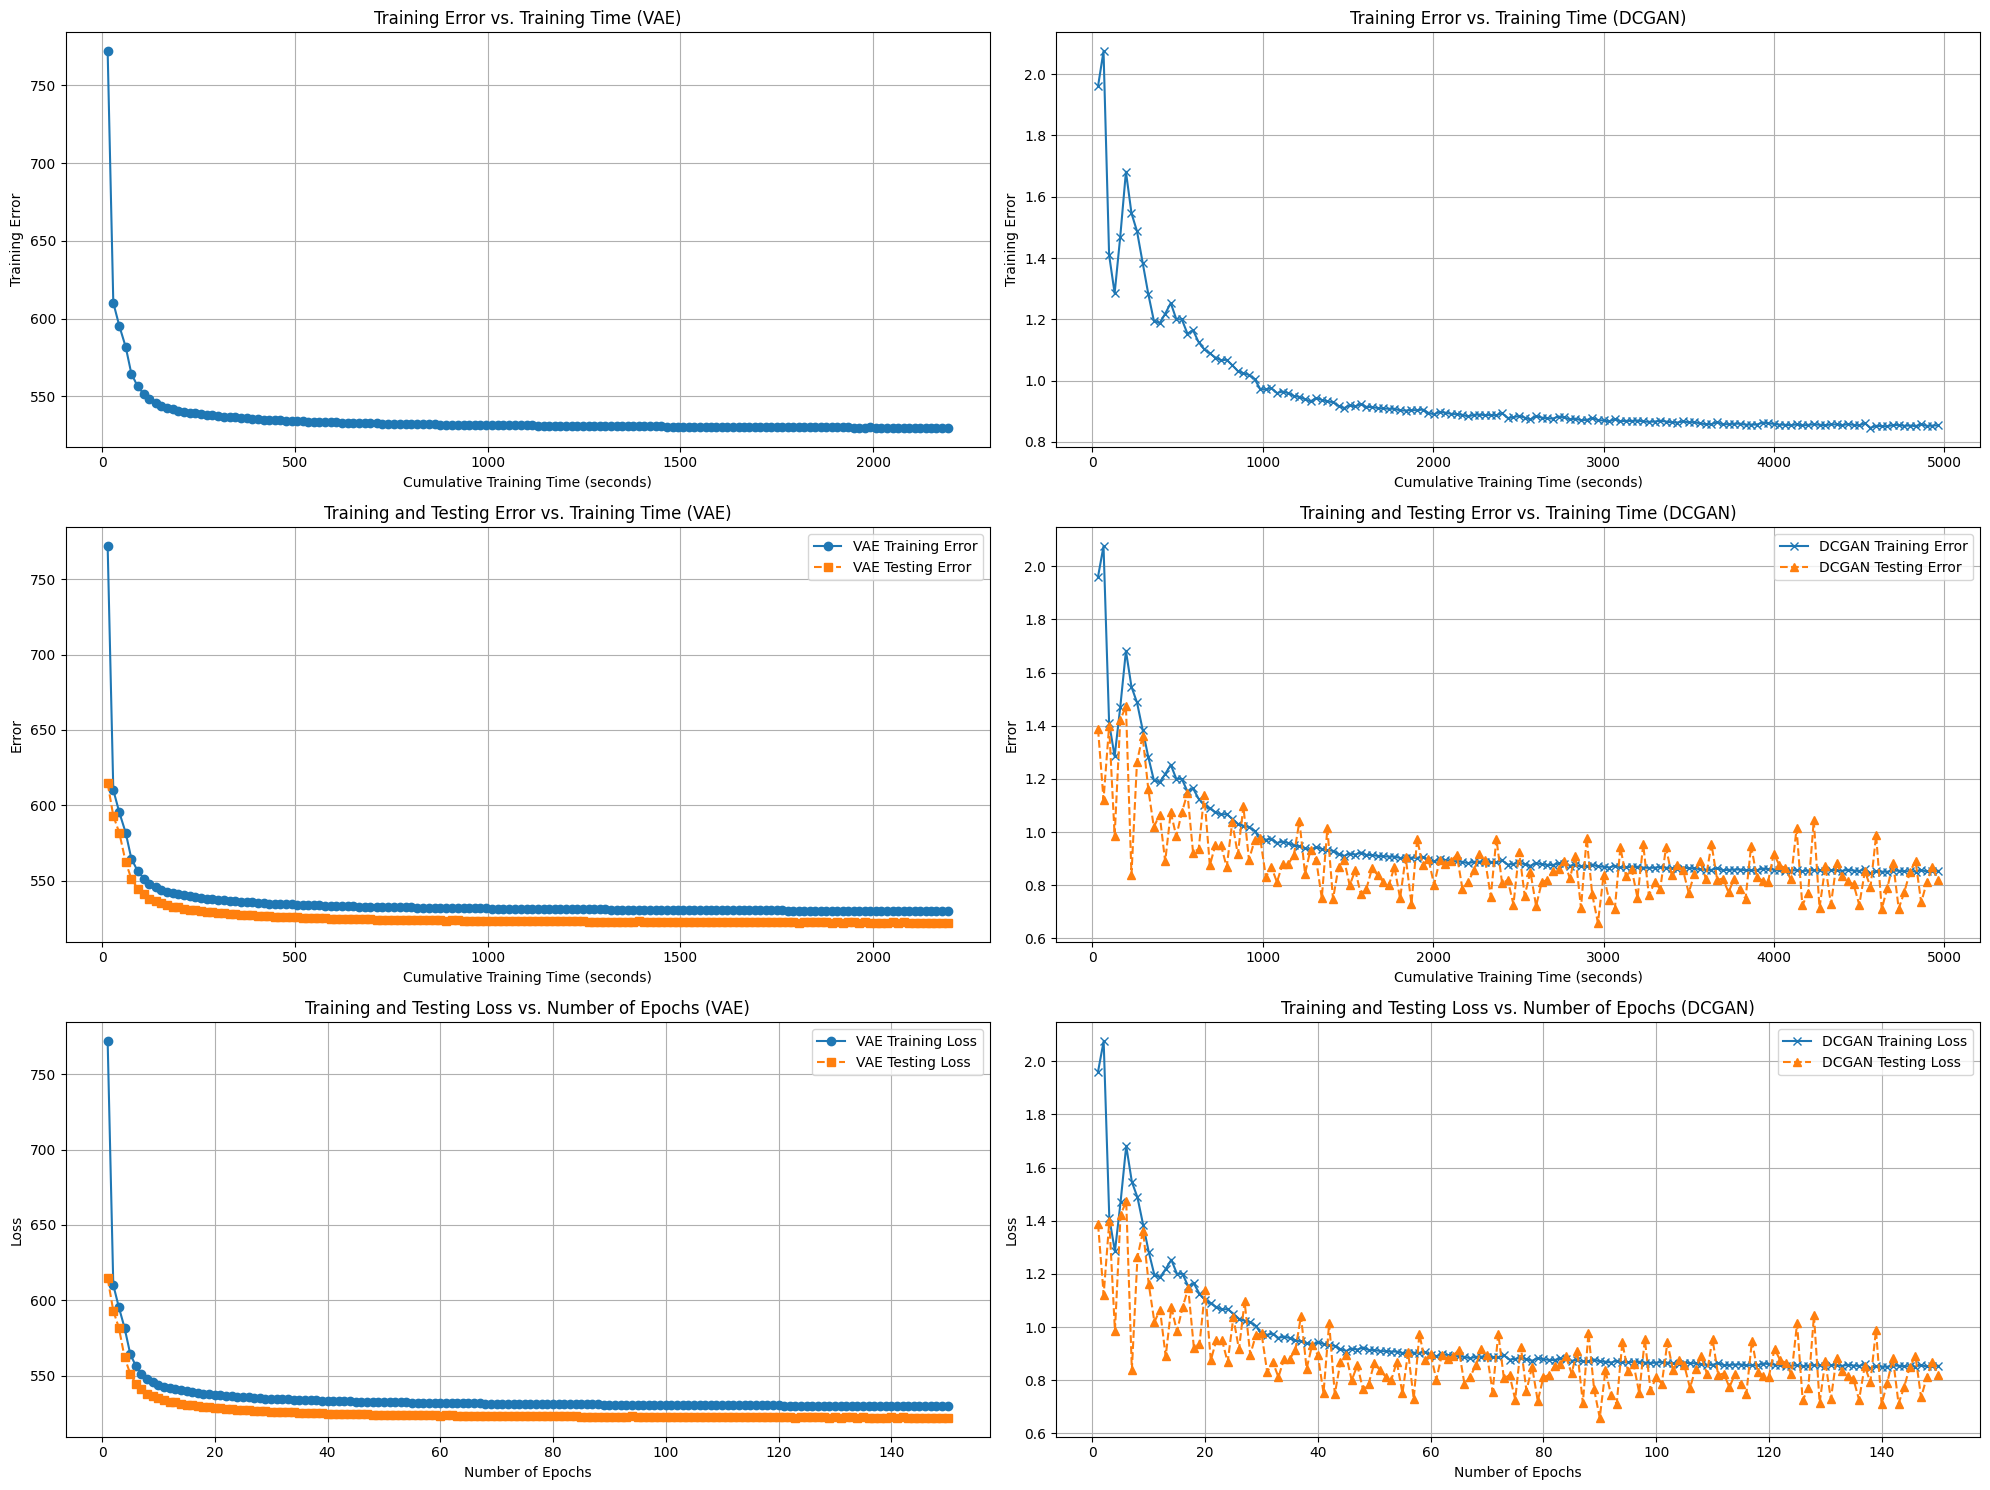

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure cumulative training times and epoch data are calculated
cumulative_time_vae = np.cumsum(vae_epoch_times)
cumulative_time_dcgan = np.cumsum(dcgan_epoch_times)
epochs = range(1, num_epochs + 1)

# Create a figure with 6 subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Plot 1: Training error (y-axis) vs. Training time (x-axis) for VAE
axes[0, 0].plot(cumulative_time_vae, train_loss_vae, label='VAE Training Error', marker='o', linestyle='-')
axes[0, 0].set_title('Training Error vs. Training Time (VAE)')
axes[0, 0].set_xlabel('Cumulative Training Time (seconds)')
axes[0, 0].set_ylabel('Training Error')
axes[0, 0].grid(True)

# Plot 2: Training error (y-axis) vs. Training time (x-axis) for DCGAN
axes[0, 1].plot(cumulative_time_dcgan, train_loss_dcgan, label='DCGAN Training Error', marker='x', linestyle='-')
axes[0, 1].set_title('Training Error vs. Training Time (DCGAN)')
axes[0, 1].set_xlabel('Cumulative Training Time (seconds)')
axes[0, 1].set_ylabel('Training Error')
axes[0, 1].grid(True)

# Plot 3: Training error and Testing error (y-axis) vs. Training time (x-axis) for VAE
axes[1, 0].plot(cumulative_time_vae, train_loss_vae, label='VAE Training Error', marker='o', linestyle='-')
axes[1, 0].plot(cumulative_time_vae, test_loss_vae, label='VAE Testing Error', marker='s', linestyle='--')
axes[1, 0].set_title('Training and Testing Error vs. Training Time (VAE)')
axes[1, 0].set_xlabel('Cumulative Training Time (seconds)')
axes[1, 0].set_ylabel('Error')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Training error and Testing error (y-axis) vs. Training time (x-axis) for DCGAN
axes[1, 1].plot(cumulative_time_dcgan, train_loss_dcgan, label='DCGAN Training Error', marker='x', linestyle='-')
axes[1, 1].plot(cumulative_time_dcgan, test_loss_dcgan, label='DCGAN Testing Error', marker='^', linestyle='--')
axes[1, 1].set_title('Training and Testing Error vs. Training Time (DCGAN)')
axes[1, 1].set_xlabel('Cumulative Training Time (seconds)')
axes[1, 1].set_ylabel('Error')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Plot 5: Training loss and testing loss (y-axis) vs. number of epochs (x-axis) for VAE
axes[2, 0].plot(epochs, train_loss_vae, label='VAE Training Loss', marker='o', linestyle='-')
axes[2, 0].plot(epochs, test_loss_vae, label='VAE Testing Loss', marker='s', linestyle='--')
axes[2, 0].set_title('Training and Testing Loss vs. Number of Epochs (VAE)')
axes[2, 0].set_xlabel('Number of Epochs')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Plot 6: Training loss and testing loss (y-axis) vs. number of epochs (x-axis) for DCGAN
axes[2, 1].plot(epochs, train_loss_dcgan, label='DCGAN Training Loss', marker='x', linestyle='-')
axes[2, 1].plot(epochs, test_loss_dcgan, label='DCGAN Testing Loss', marker='^', linestyle='--')
axes[2, 1].set_title('Training and Testing Loss vs. Number of Epochs (DCGAN)')
axes[2, 1].set_xlabel('Number of Epochs')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()
axes[2, 1].grid(True)

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()